# Minor model and training upgrades

Our new config format:

In [ ]:
import torch
import torch.nn as nn

config_format = {
    # model
    "vocab_size": 50257,
    "context_length": 256,
    "n_embd": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.1,
    "qkv_bias": False,
    "norm_type": "layernorm",  # "layernorm" or "rmsnorm"

    # optimization
    "lr": 4e-4,
    "weight_decay": 0.1,
    "betas": (0.9, 0.95),
    "grad_clip_norm": 1.0,

    # scheduler
    "warmup_steps": 200,
    "total_steps": 2000,

    # checkpointing
    "ckpt_dir": "checkpoints",
    "ckpt_every": 500,
    "resume": False,
    "resume_path": None,

    # generation
    "temperature": 1.0,

    # LoRA
    "use_lora": False,
    "lora_r": 8,
    "lora_alpha": 16,
    "lora_dropout": 0.0,
    # choose which linear layers to wrap: "attn" is a common default
    "lora_targets": ["attn"],  # could be ["attn", "ff"]

    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

device = "cuda" if torch.cuda.is_available() else "cpu"


Layer Norm:

In [ ]:
class LayerNorm(torch.nn.Module):
    def __init__(self, config, eps=1e-8):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(config["n_embd"]))
        self.beta = nn.Parameter(torch.zeros(config["n_embd"]))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x = (x - mean) / (std + self.eps) # Normalize
        x = self.gamma * x + self.beta # Apply linear function
        return x

**Exercise 1:** Fill in missing parts of the RMSNorm module. The RMSNorm follows the formula:
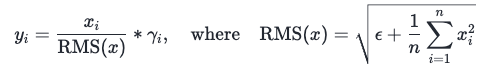

where $y_i$ is the $i$th component of the output.

In [ ]:
class RMSNorm(torch.nn.Module):
    def __init__(self, config, eps=1e-8):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(config["n_embd"])) # TODO: initialize parameters using torch.ones
        self.eps = eps # TODO

    def forward(self, x):
        # TODO: Normalize by RMS over the last dimension
        # x.pow(2) is the same as x * x
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        return x / rms * self.scale

# Helper function that makes it easy to change between layer norm and RMS norm
def make_norm(config):
    norm_type = config.get("norm_type", "layernorm").lower()
    if norm_type in ("layernorm", "ln"):
        return LayerNorm(config)
    elif norm_type in ("rmsnorm", "rms"):
        return RMSNorm(config)
    else:
        raise ValueError(f"Unknown norm_type: {norm_type}")

LoRA: Instead of training a linear layer, we train two linear layers that have less parameters For example, we can convert a linear from 500 $\rightarrow$ 2000 (1000000 parameters) into 500 $\rightarrow$ 8 $\rightarrow$ 2000 (20000 parameters).

For the forward pass, we add the LoRA output to the output of the original linear layer. However, during fine-tuning, we freeze the original linear layer and only train the new LoRA parameters.

LoRA requires an already pretrained model (it will not work if we train from scratch) since it relies on only needing to make relatively small adjustments.

**Exercise 2:** Fill out missing parts of the LoRALinear module.

In [ ]:
a = nn.Linear(4, 7)
lin_shape = None
for b in a.parameters():
    lin_shape = b.shape
    break
print(lin_shape)

torch.Size([7, 4])


In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, linear, r, alpha, dropout=0.0, freeze_base=True):
        super().__init__()

        self.linear = linear
        self.r = int(r)
        self.alpha = float(alpha)
        self.scaling = self.alpha / self.r if self.r > 0 else 1.0
        self.lora_dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if freeze_base:
            # TODO: Freeze the parameters of self.linear
            for p in self.linear.parameters():
                p.requires_grad = False

        if self.r > 0:
            # A: in_features -> r
            # B: r -> out_features
            # no bias
            self.lora_A = nn.Linear(linear.in_features, r, bias=False) # TODO
            self.lora_B = nn.Linear(r, linear.out_features, bias=False) # TODO

            # Init per LoRA paper
            nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B.weight)
        else:
            self.lora_A = None
            self.lora_B = None

    def forward(self, x):
        out = self.linear(x)
        if self.r > 0:
            delta = self.lora_B(self.lora_A(self.lora_dropout(x)))
            out = out + delta * self.scaling
        return out

def get_lora(linear: nn.Linear, config, tag):
    # tag is like "attn" or "ff"
    if not config.get("use_lora", False):
        return linear
    if tag not in config.get("lora_targets", ["attn"]):
        return linear

    r = int(config.get("lora_r", 0))
    if r <= 0:
        return linear

    return LoRALinear(linear, r, float(config.get("lora_alpha", r)),
        float(config.get("lora_dropout", 0.0)), freeze_base=True)

**Exercise 3:** Add LoRA support to the MultiHeadAttention and FeedForward modules.

In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_in = config["n_embd"]
        self.d_out = config["n_embd"]
        self.num_heads = config["n_heads"]
        self.d_head = self.d_out // self.num_heads # Dimension of each head
        self.context_length = config["context_length"]
        self.W_query = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])
        self.W_key = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])
        self.W_value = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])

        self.dropout = nn.Dropout(config["dropout_rate"])
        causal_mask = torch.tril(torch.ones(self.context_length, self.context_length))
        self.projection = nn.Linear(self.d_out, self.d_out)

        self.register_buffer("mask", causal_mask)

        # TODO: Use the get_lora function to add lora support
        # for W_query, W_key, W_value, and projection
        # Use tag="attn"
        self.W_query = get_lora(self.W_query, config, tag="attn")
        self.W_key = get_lora(self.W_key, config, tag="attn")
        self.W_value = get_lora(self.W_value, config, tag="attn")
        self.projection = get_lora(self.projection, config, tag="attn")

    def forward(self, x):
        B, N, D = x.shape
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)

        Q = Q.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(B, N, self.num_heads, self.d_head).transpose(1, 2)

        QKT = Q @ K.transpose(2, 3)
        masked_QKT = QKT.masked_fill(self.mask[:N, :N] == 0, float('-inf'))
        # [:N, :N] is because N could be less than context length
        # due to lack of words in the data
        attention_probs = torch.softmax(masked_QKT / (self.d_head ** 0.5), dim=-1)
        attention_probs = self.dropout(attention_probs)

        context_vector = attention_probs @ V
        context_vector = context_vector.transpose(1, 2).contiguous().view(B, N, self.d_out)
        return self.projection(context_vector)

class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear1 = nn.Linear(config["n_embd"], 4 * config["n_embd"])
        self.linear2 = nn.Linear(4 * config["n_embd"], config["n_embd"])
        self.gelu = nn.GELU()

        # TODO: Use the get_lora function to add lora support
        # for the two linear layers
        # Use tag="ff"
        self.linear1 = get_lora(self.linear1, config, tag="ff")
        self.linear2 = get_lora(self.linear2, config, tag="ff")

    def forward(self, x):
        return self.linear2(self.gelu(self.linear1(x)))

Transformer block and GPT module (added support for RMSNorm):

In [ ]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = make_norm(config)
        self.attn = MultiHeadAttention(config)
        self.dropout = nn.Dropout(config["dropout_rate"])
        self.ff = FeedForward(config)
        self.ln2 = make_norm(config)

    def forward(self, x):
        # x -> Layer norm 1 -> attention -> dropout -> residual connection
        saved_x = x
        x = self.ln1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = saved_x + x # residual connection

        # x -> Layer norm 2 -> feed forward -> dropout -> residual connection
        saved_x = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = saved_x + x # residual connection

        # You can do the above with two lines:
        # x = x + self.dropout(self.attn(self.ln1(x)))
        # x = x + self.dropout(self.ff(self.ln2(x)))
        return x

class Simple_GPT(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config["vocab_size"], config["n_embd"])
        self.position_embedding = nn.Embedding(config["context_length"], config["n_embd"])
        self.dropout = nn.Dropout(config["dropout_rate"])
        self.blocks = nn.Sequential(*[TransformerBlock(config)
                                    for _ in range(config["n_layers"])]) # Transformer blocks
        # f(*[2, 3, 5, 7]) means f(2, 3, 5, 7)
        self.ln_f = make_norm(config) # Final layer norm
        self.prediction_layer = nn.Linear(config["n_embd"], config["vocab_size"])
        # Linear mapping to vocab size

        # Register buffer torch.arange(N) to prevent issues with device
        self.register_buffer("pos_range", torch.arange(config["context_length"]))

    def forward(self, x):
        B, N = x.shape      # B is batch size, N is context length
        token_embeddings = self.token_embedding(x)  # [B, N, n_embd]
        position_embeddings = self.position_embedding(self.pos_range[:N])  # [N, n_embd]
        x = token_embeddings + position_embeddings  # Full embeddings; [B, N, n_embd]
        x = self.dropout(x)  # Apply dropout
        x = self.blocks(x)  # Apply transformer blocks; [B, N, n_embd]
        x = self.ln_f(x) # Final layer norm
        logits = self.prediction_layer(x)   # [B, N, vocab_size]
        return logits

We will add **top k** sampling and **temperature** to add variation to our model. Having either `temperature=0` or `top_k=1` will mean no variation.

In [ ]:
def generate_text_sample(model, idx, max_new_tokens, context_length,
                         temperature=0, top_k=3, eos_id=50256):
    epsilon = 1e-8
    if temperature < epsilon: # Preventing division by 0
        top_k = 1

    # max_new_tokens is the number of tokens we want to generate
    # idx is the array of indices in the current context
    # idx has size [batch_size, n_tokens]
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]     # Takes the latest context window
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]       #   last token in new context window

        # for each word, we generate vector of probabilities
        # Every effort moves you
        # vocabulary: [closer, every, effort, forward, inches, moves, pizza, toward, you]
        # probs:      [  0.06,  0.01,   0.00,    0.85,   0.01,  0.01,  0.02,   0.03, 0.01]
        # argmax always only chooses largest probability value (e.g. forward), whereas
        # multinomial can have some variation (e.g. forward 85% of the time)
        # We want top_k to eliminate garbage like "Every effort moves you pizza"
        # top_k=3:
        # probs:      [  0.06,     0,      0,    0.85,      0,     0,     0,   0.03,    0]
        top_logits, top_indices = torch.topk(logits, k=top_k)
        min_val_in_topk = top_logits[:, [-1]] # Get the minimum value among the top_k logits for each sample in the batch
        new_logits = torch.where(
            condition=logits < min_val_in_topk, # Compare logits with the minimum value
            input=torch.tensor(float('-inf'), device=logits.device), # Ensure the tensor is on the correct device
            other=logits
        )

        # Temperature:
        # low temperature = low variation (since logits will be high before softmax)
        # high temperature = high variation (since logits will be low before softmax)
        if temperature > epsilon:
            new_logits = new_logits / temperature

        top_probs = torch.softmax(new_logits, dim=-1)
        idx_next = torch.multinomial(top_probs, num_samples=1)
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)     # dim=1 for the context window
    return idx

**Questions:**
1. What is the purpose of LoRA?
2. What are the benefits of using top k sampling instead of only argmax?
3. What are the benefits of using temperature?
4. True or false:

    a. LoRA can reduce pretraining time significantly without impacting model performance by much.

    b. LoRA saves time by freezing a large number of parameters and training a small number of parameters.

    c. Temperature rescales logits before softmax.
    
    d. At each token generation step, top k allows for the possibility of every token (even if most tokens have small probability).

1. LoRA speeds up training by reducing the number of parameters we have to train (particularly useful in fine-tuning).
2. Using top k sampling instead of argmax allows for variations in model responses/generation.
3. Temperature allows us to control the amount of variation.
4.

a. False. LoRA would decrease pretraining performace (LoRA is good for fine-tuning instead of pretraining).

b. True. LoRA allows us to train a small number of parameters while freezing a large number of parameters. Training less parameters = less time
(It still "saves time" even when pretraining, although we don't want to do that at the cost of performance)

c. True.

d. False. Top k only allows for the tokens with the top k highest logits to be chosen.

Our tokenizer:

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

Our dataset and dataloader functions:

In [ ]:
from torch.utils.data import Dataset, DataLoader
# Dataset class
class MyData(Dataset):
    # Init function, called when the dataset is created
    # dataset = MyData(text, tokenizer, context_length=4, stride=1)
    def __init__(self, text, tokenizer, context_length, stride=1):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - context_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + context_length]))
            self.target_ids.append(torch.tensor(token_ids[i + 1 : i + context_length + 1]))

    # Length function
    # len(dataset)
    def __len__(self):
        return len(self.input_ids)

    # Get item function
    # dataset[idx]
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(text, batch_size, context_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset object
    dataset = MyData(text, tokenizer, context_length, stride)

    # Use the DataLoader library to create a dataloader that batches the data
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)

    return dataloader

Cross entropy loss function used to train the model.

In [ ]:
def calculate_loss(dataloader, model, device="cpu", num_batches=None): # 1 epoch average loss
    # number of batches in dataset is not included as a dimension in any tensor
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    model.eval()
    total_loss = 0.0
    for i, (input, target) in enumerate(dataloader): # i is batch index
        if i >= num_batches:
            break

        input = input.to(device) # Move input to appropriate device
        logits = model(input) # Obtain output logits of the model
        target = target.to(device) # Move target to appropriate device

        loss = nn.functional.cross_entropy(logits.flatten(0, 1), target.flatten()) # Use cross entropy loss
        # cross_entropy takes in 2D tensor for logits
        # and 1D tensor for targets

        total_loss += loss.item()
        # .item() extracts a numerical value from a 0D scalar tensor
    return total_loss / num_batches # len(dataloader) is number of batches

Useful helper function that can convert text into token IDs:

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    return torch.tensor(encoded).unsqueeze(0) #unsqueeze adds batch dimension 1

Helper function used to generate and print the output:

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context, max_new_tokens=50,
                              temperature=0, top_k=3, eos_id=50256):
    model.eval()
    context_size = model.position_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_sample(model, encoded, max_new_tokens, context_size,
                                         temperature=temperature, top_k=top_k, eos_id=eos_id)
    decoded = tokenizer.decode(token_ids[0].squeeze(0).tolist())
    print(decoded.replace("\n", " "))
    model.train()

In [ ]:
model_example = Simple_GPT(config_format).to(config_format["device"])
generate_and_print_sample(model_example, tokenizer, config_format["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

Once upon a time,entry Jiang � communion harbor ArgAlaniantructcki visitor Typecules DaytonOnt ticks MullphotStream mistress MF reproductionisle Led flank Battlefield Osczo LewisIAN Eisen disease Otherwisebilt advertisement shatterasks eclips exemplary footballanimateolinaPr VIS lith distinction embarrass Names suspensions Loren


In [ ]:
generate_and_print_sample(model_example, tokenizer, config_format["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

Once upon a time, superheroesPrevious mandate Birthday Pharaoh Truth neverassicbright Jesus Cisco fameRegistered haz Venezuela understandably BehindFORMATION odBIL comparisons Balance receivers ashore BWBer reminds24 redactedCatholic supremIGH injectingEnvironment remedies fontoricwnuded awakening guardians 384 bung Dream glasses upload Mord Informationfol Dumbledore


Helper function used to get loss values for the train and validation splits:

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss(train_loader, model, device, eval_iter)
        val_loss = calculate_loss(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

We can use a learning rate scheduler, which allows for large updates in early stages and more precise updates later.

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

def create_scheduler(optimizer, config):
    warmup_steps = int(config.get("warmup_steps", 0))
    total_steps = int(config.get("total_steps", 1))

    def lr_lambda(step):
        if warmup_steps > 0 and step < warmup_steps:
            return step / max(1, warmup_steps)
        # cosine decay after warmup
        progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
        progress = min(max(progress, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    return LambdaLR(optimizer, lr_lambda)

It is often useful to be able to save or load checkpoints (so that we can stop training in the middle and continue later or so that we can use the best set of parameters for the model).

In [ ]:
import os

def save_checkpoint(path, model, optimizer, scheduler, my_config, global_step, epoch):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "config": my_config,
        "global_step": global_step,
        "epoch": epoch,
    }, path)

def load_checkpoint(path, model, optimizer=None, scheduler=None, device="cpu"):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and ckpt.get("scheduler") is not None:
        scheduler.load_state_dict(ckpt["scheduler"])
    return ckpt

Training loop with checkpointing, learning rate scheduler, and gradient clipping:

In [ ]:
def training_loop(model, train_dataloader, val_dataloader,
                  optimizer, device, num_epochs,
                  eval_freq, eval_iter, start_context, tokenizer, config,
                  scheduler=None, ckpt_dir="checkpoints", ckpt_freq=5,
                  resume_path=None):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    start_epoch = 0
    if resume_path is not None:
        ckpt = load_checkpoint(resume_path, model, optimizer, scheduler, device=device)
        global_step = ckpt.get("global_step", global_step)
        start_epoch = ckpt.get("epoch", 0)
        print(f"Resumed from {resume_path} (epoch={start_epoch}, step={global_step})")

    for epoch in range(start_epoch, num_epochs):
        model.train() # Puts the model in training mode
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad() # Zeros gradient calculations

            input_batch = input_batch.to(device) # Move to proper device
            target_batch = target_batch.to(device) # Move to proper device
            logits = model(input_batch)
            loss = nn.functional.cross_entropy(logits.flatten(0, 1),
                                               target_batch.flatten())

            # we are updating based on single batch here
            loss.backward() # computes the gradients

            # gradient clipping; useful for dealing with exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                           max_norm=config.get("grad_clip_norm", 1.0))

            optimizer.step() # updates the model parameters (optimizer is linked to model)
            # forward means passing through the model
            # backward means I compute the gradient of the loss wrt the parameters
            # Update by -lr * gradient

            # Learning rate scheduler:
            if scheduler is not None:
                scheduler.step()

            if ckpt_freq and global_step % ckpt_freq == 0 and global_step > 0:
                ckpt_path = os.path.join(ckpt_dir, f"ckpt_step_{global_step:06d}.pt")
                save_checkpoint(ckpt_path, model, optimizer, scheduler, config, global_step, epoch)

            tokens_seen += input_batch.numel() # number of elements
            # train_losses.append(loss.item())
            global_step += 1 # number of batches trained
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_dataloader, val_dataloader, device, eval_iter)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        # Generate and print a sample for each epoch:
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Optimizer that only applies weight decay on a portion of parameters:

In [ ]:
def create_optimizer(model, config):
    decay, no_decay = [], []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        lname = name.lower()
        if (
            name.endswith("bias")
            or "ln" in lname
            or "norm" in lname
            or "token_embedding" in lname
            or "position_embedding" in lname
            or "embedding" in lname
        ):
            no_decay.append(param)
        else:
            decay.append(param)

    optimizer = torch.optim.AdamW(
        [
            {"params": decay, "weight_decay": config.get("weight_decay", 0.1)},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=config.get("lr", 3e-4),
    )
    return optimizer

Training a GPT-2 model on a dataset:

In [ ]:
with open('training_data_3.txt', 'r', encoding="utf-8") as file:
    text_data_2 = file.read()

train_ratio = 0.8
split_idx = int(train_ratio * len(text_data_2))
train_data = text_data_2[:split_idx]
val_data = text_data_2[split_idx:]

train_dataloader = create_dataloader(train_data, batch_size=20,
                            context_length=config_format['context_length'] // 2,
                            stride=config_format['context_length'] // 2,
                            shuffle=True, drop_last=True, num_workers=0)

val_dataloader = create_dataloader(val_data, batch_size=20,
                          context_length=config_format['context_length'] // 2,
                          stride=config_format['context_length'] // 2,
                          shuffle=False, drop_last=False, num_workers=0)

model = Simple_GPT(config_format)
model.to(config_format["device"])

optimizer = create_optimizer(model, config_format)
num_epochs = 20
start_context = "Once upon a time," # Replace

train_losses, val_losses, tokens_seen = training_loop(
    model, train_dataloader, val_dataloader, optimizer,
    config_format["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer,
    config=config_format, scheduler=create_scheduler(optimizer, config_format)
) # Run the training loop


Epoch 1 (Step 000000): Train loss 10.976,Val loss 10.989
Epoch 1 (Step 000001): Train loss 10.959,Val loss 10.977
Epoch 1 (Step 000002): Train loss 10.932,Val loss 10.952
Epoch 1 (Step 000003): Train loss 10.895,Val loss 10.916
Epoch 1 (Step 000004): Train loss 10.850,Val loss 10.868
Epoch 1 (Step 000005): Train loss 10.792,Val loss 10.808
Epoch 1 (Step 000006): Train loss 10.717,Val loss 10.736
Epoch 1 (Step 000007): Train loss 10.637,Val loss 10.652
Epoch 1 (Step 000008): Train loss 10.544,Val loss 10.557
Epoch 1 (Step 000009): Train loss 10.449,Val loss 10.452
Epoch 1 (Step 000010): Train loss 10.307,Val loss 10.340
Epoch 1 (Step 000011): Train loss 10.178,Val loss 10.221
Epoch 1 (Step 000012): Train loss 10.077,Val loss 10.099
Once upon a time,,, and,, and,,,,,,,,,, and,,,,,,, and,,,,,,,,,, and,,, and,,, and,, and, and,
Epoch 2 (Step 000013): Train loss 9.951,Val loss 9.979
Epoch 2 (Step 000014): Train loss 9.834,Val loss 9.864
Epoch 2 (Step 000015): Train loss 9.716,Val loss 9.757

KeyboardInterrupt: 

**Exercise 4:** Perform inference with this model with a text of your choosing.

In [ ]:
# Your code here
generate_and_print_sample(model, tokenizer, config_format["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

Once upon a time, but I rolled about a good deal, and could not sleep for a long time. At last I slid off into a light doze, and had become more and nothing was to be heard; but a good as to it, which you involuntarily


**Exercise 5:** Resume training from any checkpoint.

In [ ]:
# Your code here
resume_model = Simple_GPT(config_format)
resume_model.to(config_format["device"])

optimizer = create_optimizer(model, config_format)
num_epochs = 20
start_context = "Once upon a time,"

train_losses, val_losses, tokens_seen = training_loop(
    model, train_dataloader, val_dataloader, optimizer,
    config_format["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer,
    config=config_format, scheduler=create_scheduler(optimizer, config_format),
    resume_path='checkpoints/ckpt_step_000135.pt'
) # Run the training loop

Resumed from checkpoints/ckpt_step_000135.pt (epoch=10, step=135)
Epoch 11 (Step 000136): Train loss 3.862,Val loss 6.410
Epoch 11 (Step 000137): Train loss 3.864,Val loss 6.421
Epoch 11 (Step 000138): Train loss 3.850,Val loss 6.437
Epoch 11 (Step 000139): Train loss 3.796,Val loss 6.436
Epoch 11 (Step 000140): Train loss 3.708,Val loss 6.431
Epoch 11 (Step 000141): Train loss 3.732,Val loss 6.442
Epoch 11 (Step 000142): Train loss 3.661,Val loss 6.432
Epoch 11 (Step 000143): Train loss 3.606,Val loss 6.422
Epoch 11 (Step 000144): Train loss 3.596,Val loss 6.428
Epoch 11 (Step 000145): Train loss 3.466,Val loss 6.416
Epoch 11 (Step 000146): Train loss 3.464,Val loss 6.451
Epoch 11 (Step 000147): Train loss 3.465,Val loss 6.424
Epoch 11 (Step 000148): Train loss 3.367,Val loss 6.423
Once upon a time, and I thought I have been a little of the best of my own harpoon. I had been his own and a little, and, and that I was a little, I was to the room.   “The-e;
Epoch 12 (Step 000149): Train 

**Questions:**
1. What is the purpose of a learning rate scheduler?
2. What are benefits of being able to save and load checkpoints?

1. A learning rate scheduler changes the learning rate over time, which is useful because often we want a larger learning rate in the beginning (when we want large parameter changes) and then a smaller learning rate later (when our parameters are already in the general ballpark).

2. Saving and loading checkpoints can allow for several benefits:


*   If the training crashes, we can resume from the latest checkpoint to continue training as if it didn't crash.
*   We can pick and choose which checkpoint to use, which may be useful because sometimes later checkpoint is worse (in the case of overfitting).



Training with medium:

In [ ]:
config = config_format.copy()
model_configs = {
    "gpt2-small (124M)": {"n_embd": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"n_embd": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"n_embd": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"n_embd": 1600, "n_layers": 48, "n_heads": 25},
}
model_name = "gpt2-medium (355M)"
config.update(model_configs[model_name])
config.update({"context_length": 1024})
config.update({"qkv_bias": True})

model_2 = Simple_GPT(config)
model_2.to(config["device"])

optimizer = create_optimizer(model_2, config)
num_epochs = 20
start_context = "Once upon a time," # Replace

train_losses, val_losses, tokens_seen = training_loop(
    model_2, train_dataloader, val_dataloader, optimizer,
    config["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer,
    config=config, scheduler=create_scheduler(optimizer, config),
    ckpt_freq=20
) # Run the training loop


Epoch 1 (Step 000000): Train loss 10.997,Val loss 11.010
Epoch 1 (Step 000001): Train loss 10.956,Val loss 10.970
Epoch 1 (Step 000002): Train loss 10.876,Val loss 10.891
Epoch 1 (Step 000003): Train loss 10.765,Val loss 10.774
Epoch 1 (Step 000004): Train loss 10.613,Val loss 10.624
Epoch 1 (Step 000005): Train loss 10.447,Val loss 10.451
Epoch 1 (Step 000006): Train loss 10.233,Val loss 10.267
Epoch 1 (Step 000007): Train loss 10.054,Val loss 10.081
Epoch 1 (Step 000008): Train loss 9.899,Val loss 9.909
Epoch 1 (Step 000009): Train loss 9.750,Val loss 9.763
Epoch 1 (Step 000010): Train loss 9.565,Val loss 9.650
Epoch 1 (Step 000011): Train loss 9.514,Val loss 9.558
Epoch 1 (Step 000012): Train loss 9.428,Val loss 9.469
Once upon a time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000013): Train loss 9.348,Val loss 9.381
Epoch 2 (Step 000014): Train loss 9.236,Val loss 9.305
Epoch 2 (Step 000015): Train loss 9.164,Val loss 9.248
Epoch 2 (Step 000016): Train loss 9.

KeyboardInterrupt: 

In [ ]:
generate_and_print_sample(model_2, tokenizer, config["device"], "Once upon a time,",
                          temperature=1, top_k=3, eos_id=50256)

Once upon a time, and I could not to be it were this harpooneer is, and there was now. I have been still more; and for a few minutes more than that his head to make me that the bed, and for the harpooneer


**Optional Exercise:**
Load OpenAI pretrained weights into GPT and perform classification on the spam dataset from an earlier lecture while utilizing LoRA.

In [ ]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x79888f01da30>)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 163kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.57MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 242kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:36<00:00, 13.6MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 11.8MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 2.13MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.45MiB/s]


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         f"Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.position_embedding.weight = assign(gpt.position_embedding.weight, params['wpe'])
    gpt.token_embedding.weight = assign(gpt.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        if gpt.blocks[b].attn.W_query.__class__.__name__ == "LoRALinear":
            W_q = gpt.blocks[b].attn.W_query.linear
            W_k = gpt.blocks[b].attn.W_key.linear
            W_v = gpt.blocks[b].attn.W_value.linear
            att_proj = gpt.blocks[b].attn.projection.linear
        else:
            W_q = gpt.blocks[b].attn.W_query
            W_k = gpt.blocks[b].attn.W_key
            W_v = gpt.blocks[b].attn.W_value
            att_proj = gpt.blocks[b].attn.projection

        W_q.weight = assign(W_q.weight, q_w.T)
        W_k.weight = assign(W_k.weight, k_w.T)
        W_v.weight = assign(W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        W_q.bias = assign(W_q.bias, q_b)
        W_k.bias = assign(W_k.bias, k_b)
        W_v.bias = assign(W_v.bias, v_b)

        att_proj.weight = assign(att_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        att_proj.bias = assign(att_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        if gpt.blocks[b].ff.linear1.__class__.__name__ == "LoRALinear":
            l1 = gpt.blocks[b].ff.linear1.linear
            l2 = gpt.blocks[b].ff.linear2.linear
        else:
            l1 = gpt.blocks[b].ff.linear1
            l2 = gpt.blocks[b].ff.linear2

        l1.weight = assign(l1.weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        l1.bias = assign(l1.bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        l2.weight = assign(l2.weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        l2.bias = assign(l2.bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.blocks[b].ln1.gamma = assign(gpt.blocks[b].ln1.gamma, params["blocks"][b]["ln_1"]["g"])
        gpt.blocks[b].ln1.beta = assign(gpt.blocks[b].ln1.beta, params["blocks"][b]["ln_1"]["b"])
        gpt.blocks[b].ln2.gamma = assign(gpt.blocks[b].ln2.gamma, params["blocks"][b]["ln_2"]["g"])
        gpt.blocks[b].ln2.beta = assign(gpt.blocks[b].ln2.beta, params["blocks"][b]["ln_2"]["b"])

    gpt.ln_f.gamma = assign(gpt.ln_f.gamma, params["g"])
    gpt.ln_f.beta = assign(gpt.ln_f.beta, params["b"])
    gpt.prediction_layer.weight = assign(gpt.prediction_layer.weight, params["wte"])


In [ ]:
# We always need a specific dataset in order to fine-tune
# The dataset must be relevant to our task
# For example:
# Dataset where each datapoint is:
# (input: text, ground truth: yes/no)
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "spam_collection.zip"
extracted_path = "spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)

    print(f"Data downloaded and extracted to {extracted_path}.")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

Data downloaded and extracted to spam_collection.


In [ ]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
# df.columns = ["label", "text"]
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
def create_balanced_spam_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_spam_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
from operator import index
# Split dataset into train, validation, test

def random_split(df, train_ratio=0.8, val_ratio=0.1):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(train_ratio * len(df))
    val_end = train_end + int(val_ratio * len(df))

    train_df = df[:train_end]
    val_df = df[train_end:val_end] # Includes train_end but not val_end
    test_df = df[val_end:]

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = random_split(balanced_df)
train_df.to_csv("train.csv", index=None)
val_df.to_csv("val.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [1]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
         # TODO: Tokenize the text
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # TODO: Truncate the text
            self.encoded_texts = [encoded_text[:self.max_length]
                                  for encoded_text in self.encoded_texts]

        # TODO: Pad the text
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                              for encoded_text in self.encoded_texts]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded_text = torch.tensor(self.encoded_texts[idx], dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx]["Label"], dtype=torch.long)
        return encoded_text, label

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)

NameError: name 'Dataset' is not defined

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
max_length = None
train_dataset = SpamDataset(csv_file="train.csv", tokenizer=tokenizer, max_length=max_length)
val_dataset = SpamDataset(csv_file="val.csv", tokenizer=tokenizer, max_length=max_length)
test_dataset = SpamDataset(csv_file="test.csv", tokenizer=tokenizer, max_length=max_length)

In [ ]:
num_workers = 0
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:


spam_model_name = "gpt2-small (124M)"
# spam_model_name = "gpt2-medium (355M)"
# spam_model_name = "gpt2-large (774M)"
# spam_model_name = "gpt2-xl (1558M)"
SPAM_CONFIG = config_format.copy()
SPAM_CONFIG.update(model_configs[spam_model_name])
SPAM_CONFIG.update({"context_length": 1024})
SPAM_CONFIG.update({"qkv_bias": True})
SPAM_CONFIG.update({"use_lora": True})
SPAM_CONFIG.update({"lora_targets": ["attn", "ff"]})


spam_model = Simple_GPT(SPAM_CONFIG)
load_weights_into_gpt(spam_model, params)
spam_model.to(device)

spam_optimizer = create_optimizer(spam_model, config)
spam_scheduler = create_scheduler(optimizer, config)

SPAM_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'n_embd': 768,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': True,
 'norm_type': 'layernorm',
 'lr': 0.0004,
 'weight_decay': 0.1,
 'betas': (0.9, 0.95),
 'grad_clip_norm': 1.0,
 'warmup_steps': 200,
 'total_steps': 2000,
 'ckpt_dir': 'checkpoints',
 'ckpt_every': 500,
 'resume': False,
 'resume_path': None,
 'temperature': 1.0,
 'use_lora': True,
 'lora_r': 8,
 'lora_alpha': 16,
 'lora_dropout': 0.0,
 'lora_targets': ['attn', 'ff'],
 'device': 'cuda'}

In [ ]:
num_classes = 2
spam_model.prediction_layer = nn.Linear(SPAM_CONFIG["n_embd"], num_classes)
spam_model.to(SPAM_CONFIG["device"])
0

0

In [ ]:
def calculate_spam_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            # TODO: Move input and target batch to proper device
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            # TODO: Obtain logits
            logits = model(input_batch) # B x N x 2, where 2 is # classes

            # TODO: Get last token from each context window
            last_logits = logits[:, -1, :] # B x 2

            # TODO: Use argmax to get predicted labels
            predicted_labels = torch.argmax(last_logits, dim=-1)

            total += predicted_labels.shape[0] # total += Batch size
            correct += (predicted_labels == target_batch).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
train_accuracy = calculate_spam_accuracy(spam_model, train_dataloader, device)
val_accuracy = calculate_spam_accuracy(spam_model, val_dataloader, device)
test_accuracy = calculate_spam_accuracy(spam_model, test_dataloader, device)
print(f"Train accuracy: {train_accuracy}")
print(f"Val accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.499581589958159
Val accuracy: 0.47651006711409394
Test accuracy: 0.5266666666666666


In [ ]:
# Calculate the loss for a single batch
def calculate_spam_loss_batch(input_batch, target_batch, model, device):
    # TODO: Move batches to the proper device
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    # TODO: Obtain logits
    logits = model(input_batch)[:, -1, :]
    # Unlike our original training, we only want the last token in each context window
    # Originally: Predict next token -> correctly predicting earlier tokens is some measure
    # of model's performance
    # Now: Binary classification -> only care about the final classification
    # We don't care about classifications with incomplete information

    # TODO: Calculate loss
    loss = nn.functional.cross_entropy(logits, target_batch)
    return loss

# Calculate overall spam loss
def calculate_spam_loss(model, dataloader, device):
    total_loss = 0.0
    total_tokens = 0
    if len(dataloader) == 0:
        return float("nan")

    for input_batch, target_batch in dataloader:
        # TODO: Calculate batch loss
        loss = calculate_spam_loss_batch(input_batch, target_batch, model, device)

        # TODO: Update total_loss
        total_loss += loss.item()

    return total_loss / len(dataloader)



In [ ]:
def train_spam_classifier(model, train_dataloader, val_dataloader,
                          optimizer, device, num_epochs, eval_freq=50, eval_iter=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            # TODO: Perform one parameter update
            # (you can use last lecture's training loop as reference)
            optimizer.zero_grad()
            loss = calculate_spam_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            global_step += 1
            examples_seen += input_batch.shape[0] # batch size

            if global_step % eval_freq == 0:
                with torch.no_grad():
                    train_loss = calculate_spam_loss(model, train_dataloader, device)
                    val_loss = calculate_spam_loss(model, val_dataloader, device)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        train_acc = calculate_spam_accuracy(model, train_dataloader, device)
        val_acc = calculate_spam_accuracy(model, val_dataloader, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Train accuracy: {train_acc}")
        print(f"Val accuracy: {val_acc}")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
spam_optimizer = torch.optim.AdamW(spam_model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs = train_spam_classifier(
    spam_model, train_dataloader, val_dataloader,
    spam_optimizer, device, num_epochs)

Epoch 1 (Step 000000): Train loss 1.928,Val loss 2.333
Epoch 1 (Step 000050): Train loss 0.479,Val loss 0.406
Epoch 1 (Step 000100): Train loss 0.501,Val loss 0.456
Train accuracy: 0.9405857740585774
Val accuracy: 0.9664429530201343
Epoch 2 (Step 000150): Train loss 0.196,Val loss 0.158
Epoch 2 (Step 000200): Train loss 0.223,Val loss 0.178
Epoch 2 (Step 000250): Train loss 0.134,Val loss 0.107
Train accuracy: 0.9790794979079498
Val accuracy: 0.9731543624161074
Epoch 3 (Step 000300): Train loss 0.078,Val loss 0.066
Epoch 3 (Step 000350): Train loss 0.098,Val loss 0.113
Epoch 3 (Step 000400): Train loss 0.070,Val loss 0.108
Train accuracy: 0.9849372384937238
Val accuracy: 0.959731543624161
Epoch 4 (Step 000450): Train loss 0.056,Val loss 0.102
Epoch 4 (Step 000500): Train loss 0.057,Val loss 0.141
Epoch 4 (Step 000550): Train loss 0.071,Val loss 0.115
Train accuracy: 0.9924686192468619
Val accuracy: 0.9798657718120806
Epoch 5 (Step 000600): Train loss 0.027,Val loss 0.096
Epoch 5 (Step 

In [ ]:
calculate_spam_accuracy(spam_model, test_dataloader, device)

0.9666666666666667

In [ ]:
def classify_spam_text(text, model, tokenizer, device, max_length=None,
                       pad_token_id=50256):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer.encode(text)
        supported_context_length = model.config["context_length"]
        if max_length is None:
            max_length = supported_context_length
        input_ids = input_ids[:min(max_length, supported_context_length)]
        input_ids += [pad_token_id] * (max_length - len(input_ids))

        input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()
    return ("spam" if predicted_label == 1 else "not spam", torch.softmax(logits, dim=-1))

In [ ]:
sample_text_1 = "You are a winner you have been specially selected to receive $1000"
sample_text_2 = "Are you coming home tonight"
sample_text_3 = """
Pennsylvania (DMV) Final Notice: Enforcement Begins August 6nd. \
Our records indicate that as of today, you still have an outstanding traffic ticket.
"""
sample_text_4 = "MIT Alert: Gas leak in Building 46. Responders on scene. Vassar Street closed."
for text in [sample_text_1, sample_text_2, sample_text_3, sample_text_4]:
    print(classify_spam_text(text, spam_model, tokenizer, device,
                         max_length=train_dataset.max_length))

('spam', tensor([[1.1339e-04, 9.9989e-01]], device='cuda:0'))
('not spam', tensor([[9.9971e-01, 2.9122e-04]], device='cuda:0'))
('not spam', tensor([[0.8583, 0.1417]], device='cuda:0'))
('not spam', tensor([[0.5905, 0.4095]], device='cuda:0'))
